In [1]:
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute
from qiskit.quantum_info import DensityMatrix, partial_trace
from qiskit.visualization import plot_state_city
from scipy.linalg import logm

Task 1: Entanglement purification

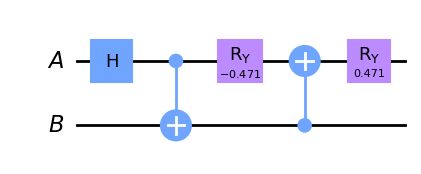

In [2]:
gamma = 0.15 * np.pi  # vary gamma to determine how entangled the state should be

alice = QuantumRegister(size=1, name="A")
bob= QuantumRegister(size=1, name="B")

qc1 = QuantumCircuit(alice, bob)
qc1.h(0)
# qc1.s(0)
qc1.cx(0, 1)
qc1.ry(-gamma, 0)
qc1.cx(1, 0)
qc1.ry(gamma, 0)

qc1.draw("mpl")

Circuit to generate entangled state with arbitrary degree of entanglement

partial trace entropy: 0.305


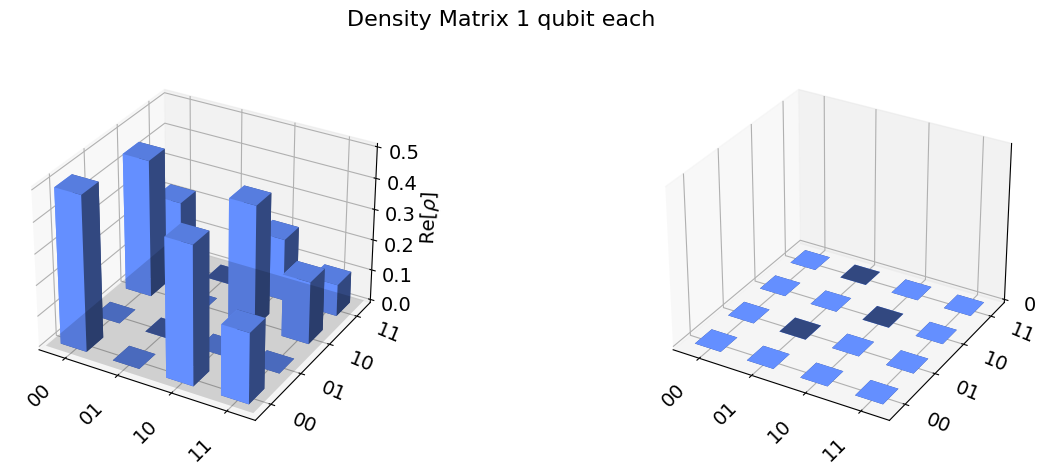

In [3]:
qc1rho = DensityMatrix.from_instruction(qc1)
rho = np.array(qc1rho)
# rho = np.diag([1, 0, 0, 0])
# print(rho)
rho_a = np.array(partial_trace(qc1rho, [(1)]))
# print(rho_a)
print(f"partial trace entropy: {np.abs(-np.trace(rho_a @ logm(rho_a))/np.log(2)):.3f}")

plot_state_city(qc1rho, title='Density Matrix 1 qubit each')

Compute entropy of the partial trace to measure entaglement

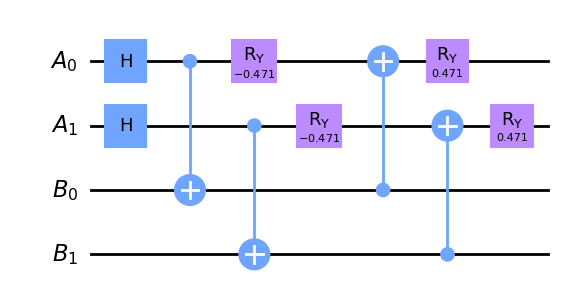

In [4]:
alice2 = QuantumRegister(size=2, name="A")
bob2 = QuantumRegister(size=2, name="B")
# c = ClassicalRegister(2)

qc2 = QuantumCircuit(alice2, bob2)
qc2.h(0)
qc2.h(1)
qc2.cx(0, 2)
qc2.cx(1, 3)
qc2.ry(-gamma, 0)
qc2.ry(-gamma, 1)
qc2.cx(2, 0)
qc2.cx(3, 1)
qc2.ry(gamma, 0)
qc2.ry(gamma, 1)

qc2.draw("mpl")

In [5]:
qc2rho = DensityMatrix.from_instruction(qc2)
first_pair = partial_trace(qc2rho, [1, 3])
rho_a = np.array(partial_trace(first_pair, [1]))
print(f"partial trace entropy first pair: {np.abs(-np.trace(rho_a @ logm(rho_a))/np.log(2)):.3f}")
second_pair = partial_trace(qc2rho, [0, 2])
rho_a = np.array(partial_trace(second_pair, [1]))
print(f"partial trace entropy second pair: {np.abs(-np.trace(rho_a @ logm(rho_a))/np.log(2)):.3f}")

partial trace entropy first pair: 0.305
partial trace entropy second pair: 0.305


Same result for 2 entangled pairs

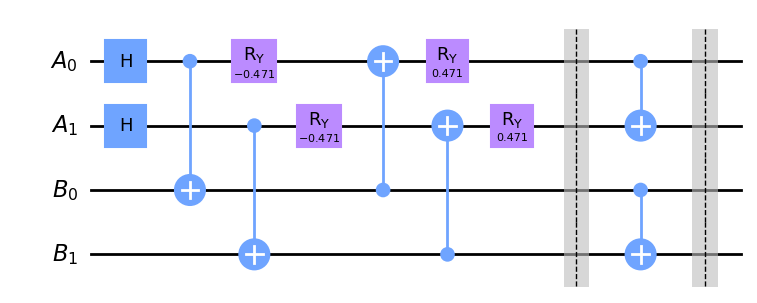

In [6]:
qc2.barrier()
qc2.cx(0, 1)
qc2.cx(2, 3)
# qc2.measure(1, 0)
# qc2.measure(3, 1)
qc2.barrier()
qc2.draw("mpl")

partial trace entropy after purification: 0.452


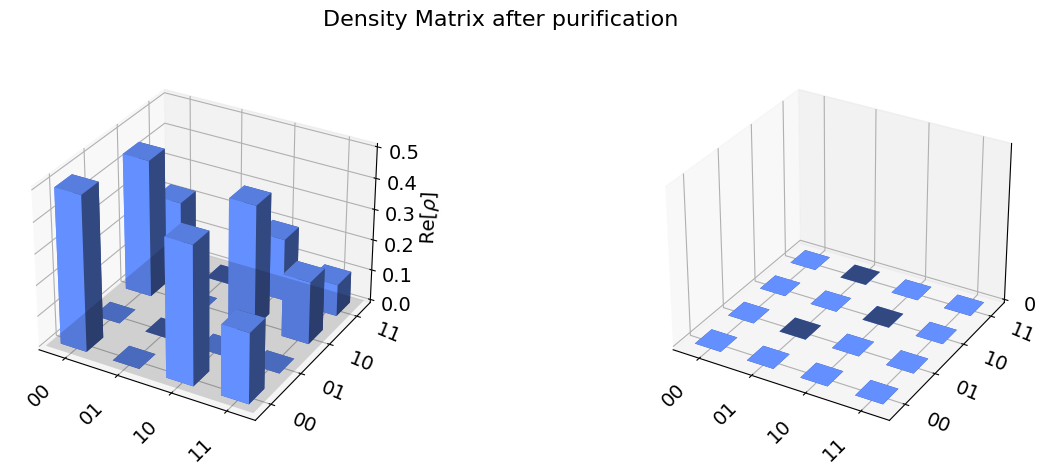

In [7]:
qc2_after_purification_rho = DensityMatrix.from_instruction(qc2)
qc2_after_measure_rho = partial_trace(qc2_after_purification_rho, [1, 3])  # partial traces simulate measurement
rho_a = np.array(partial_trace(qc2_after_measure_rho, [1]))
print(f"partial trace entropy after purification: {np.abs(-np.trace(rho_a @ logm(rho_a))/np.log(2)):.3f}")

plot_state_city(qc1rho, title='Density Matrix after purification')

After purification the new state has higher entropy

Task 2: Quantum Repeaters

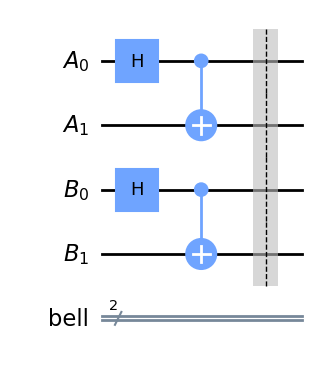

In [8]:
alice = QuantumRegister(size=2, name="A")
bob = QuantumRegister(size=2, name="B")
c = ClassicalRegister(2, name="bell")

qc_r = QuantumCircuit(alice, bob, c)

qc_r.h(0)
qc_r.h(2)
qc_r.cx(0, 1)
qc_r.cx(2, 3)
qc_r.barrier()

qc_r.draw("mpl")

Alice and Bob prepare entangled states

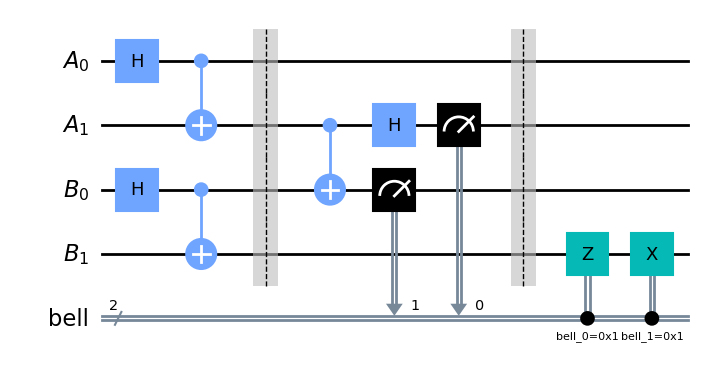

In [9]:
qc_r.cx(1, 2)
qc_r.h(1)
qc_r.measure([1, 2], [0, 1])
qc_r.barrier()
qc_r.z(3).c_if(0, 1)
qc_r.x(3).c_if(1, 1)
qc_r.draw("mpl")

Bell state measurement in the middle by reversing Bell state creation, Bob corrects his state based on classical result

In [10]:
backend = Aer.get_backend('statevector_simulator')
job = execute(qc_r, backend=backend, shots=1, memory=True)
job_result = job.result()
# print(job_result.get_statevector(qc_r))
job_result.get_statevector(qc_r).draw("latex")

<IPython.core.display.Latex object>

The first and last qubits are now in a (|00>+|11>) Bell state. In this case with perfect bells states at Alice and Bob it works reliably.